### Design of RO unit

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

In [110]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'

In [40]:
def get_C_red(x):
    '''
    S = area of membrane [m2]
    delta_p = pressure diff [Pa]
    PR = pure water flow rate [m3/hr]
    f = recovery [-]
    eta_p = pump eff. [-]
    eta_t = turbine eff. [-]
    elec_cost = cost of indust. elec. in Cali. [$/kwh]
    time_running = years plant is operating [yr]

    C_red = cost funtion, to be minimised [$]
    '''

    S, delta_p, m3 = x
    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p*PR/3600*(1/eta_p) # power of pump [Nm/s]
    P_turbine = delta_p*(PR/f-PR)/3600*eta_t # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine)/3.6e6 # [kwh/s]
    OPEX_per_s = (P_tot*elec_cost) # [$/s]
    OPEX = OPEX_per_s*time_running*8000*3600 # [$]

    membrane_cost = S*150 # [$]

    C_red = membrane_cost + OPEX
    return C_red

Equality constraint: $ \frac{A(\Delta p - \Delta \pi )\times M_B \times S \times 3600}{\frac{1000}{1000+m_3\times M_A}} - PR = 0; ~where~\Delta \pi = \sum_i R T C_{i,~feed} -  \sum_i R T C_{i,~permeate}$

In [41]:
def constraint1(x):

    S, delta_p, m3 = x

    M_A = 58.44 # [g/mol]
    M_B = 18.02 # [g/mol]
    A = 3e-7 # [kmol/(m^2skPa)]
    PR = 1500 # [m^3/hr]
    rho = 997 # [kg/m^3]
    m1 = 0.6 # [M]

    delta_pi = 0.0821*298*((m1+m1)-(m3+m3)) # using eq. above this is in atm
    delta_pi = delta_pi*101300 # atm -> Pa

    J_B = A*(delta_p/1000-delta_pi/1000) # ensuring kPa units
    cons1 = (J_B*M_B*S*3600)/(1000/(1000+m3*M_A))-PR*rho
    return cons1

$\Delta p - 800 \geq 0$ and $1000 -\Delta p\geq 0$ 
Note: this is in the form $g(x) \geq 0$

$S \geq 0$

$m_3 \geq 0$ and $0.005 - m_3 \geq 0 $

In [69]:
bounds = [(1e-6, 1e7), (5.516e6, 6.895e6), (0, 0.005)]

In [61]:
constraints = [{"type": "ineq", "fun": constraint1}]

In [76]:
x0 = [23800, 6.7e6, 0.005]

In [79]:
result = minimize(get_C_red, x0, bounds=bounds, constraints=constraints)
print("Optimal Solution:", result.x)
print("Minimum Cost:", result.fun)
print("inital constraint :", constraint1(x0))
print("Constraint :", constraint1([result.x[0], result.x[1], result.x[2]]))

Optimal Solution: [2.04819695e+04 6.69995247e+06 5.00000000e-03]
Minimum Cost: 12080009.303787978
inital constraint : 242289.48698598612
Constraint : 0.01090388116426766


In [201]:
def get_C_red(x):
    S, delta_p = x  
    m3 = 0.005  # Fix m3 at 0.005

    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p * PR / 3600 * (1 / eta_p)  # power of pump [Nm/s]
    P_turbine = delta_p * (PR / f - PR) / 3600 * eta_t  # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine) / 3.6e6  # [kwh/s]
    OPEX_per_s = P_tot * elec_cost  # [$/s]
    OPEX = OPEX_per_s * time_running * 8000 * 3600  # [$]

    membrane_cost = S * 150  # [$]

    C_red = membrane_cost + OPEX
    return C_red

def constraint1(x):
    S, delta_p = x  
    m3 = 0.005  

    M_A = 58.44  # [g/mol]
    M_B = 18.02  # [g/mol]
    A = 3e-7  # [kmol/(m^2skPa)]
    PR = 1500  # [m^3/hr]
    rho = 997  # [kg/m^3]
    m1 = 0.6  # [M]

    delta_pi = 0.0821 * 298 * ((m1 + m1) - (m3 + m3))  # using eq. above this is in atm
    delta_pi = delta_pi * 101300  # atm -> Pa

    J_B = A * (delta_p / 1000 - delta_pi / 1000)  
    cons1 = (J_B * M_B * S * 3600) / (1000 / (1000 + m3 * M_A)) - PR * rho
    return cons1

bounds = [(1e-6, 1e7), (5.516e6, 6.895e6)]

constraints = [{"type": "ineq", "fun": constraint1}]

x0 = [26240, 5.87e6] 

result = minimize(get_C_red, x0, bounds=bounds, constraints=constraints, method='SLSQP')

print("Optimal Solution:", result.x)
print("Minimum Cost:", result.fun)
print("inital constraint:", constraint1(x0))
print("Constraint Value at Optimal Solution:", constraint1(result.x))

Optimal Solution: [  26302.12735317 5870000.08455761]
Minimum Cost: 11837208.105547968
inital constraint: -3532.512466052547
Constraint Value at Optimal Solution: 1.1292286217212677e-07


C:\Users\fjm21\AppData\Local\Temp\ipykernel_14908\2347942327.py:66: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2, label="Constraint Boundary")


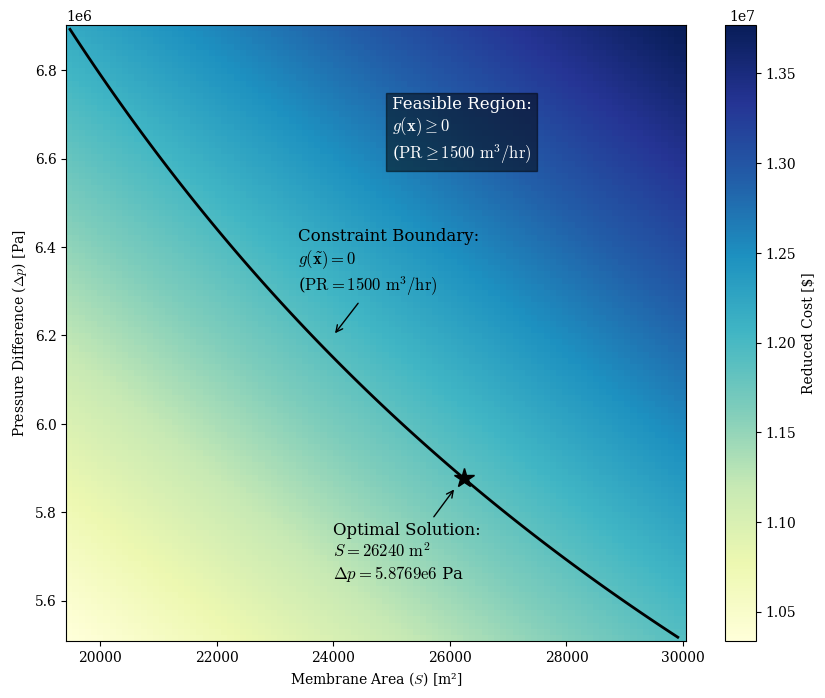

In [208]:
def constraint1(x):
    S, delta_p, m3 = x
    M_A = 58.44 # [g/mol]
    M_B = 18.02 # [g/mol]
    A = 3e-7 # [kmol/(m^2skPa)]
    PR = 1500 # [m^3/hr]
    rho = 997 # [kg/m^3]
    m1 = 0.6 # [M]

    delta_pi = 0.0821*298*((m1+m1)-(m3+m3)) # using eq. above this is in atm
    delta_pi = delta_pi*101300 # atm -> Pa

    J_B = A*(delta_p/1000 - delta_pi/1000) # ensuring kPa units
    cons1 = (J_B*M_B*S*3600)/(1000/(1000+m3*M_A))-PR*rho
    return cons1

# Define the cost function (get_C_red)
def get_C_red(x):
    '''
    S = area of membrane [m2]
    delta_p = pressure diff [Pa]
    PR = pure water flow rate [m3/hr]
    f = recovery [-]
    eta_p = pump eff. [-]
    eta_t = turbine eff. [-]
    elec_cost = cost of indust. elec. in Cali. [$/kwh]
    time_running = years plant is operating [yr]

    C_red = cost function, to be minimised [$]
    '''
    S, delta_p, m3 = x
    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p*PR/3600*(1/eta_p) # power of pump [Nm/s]
    P_turbine = delta_p*(PR/f-PR)/3600*eta_t # power recovered by turbine [Nm/s]
    P_tot = (P_pump - P_turbine)/3.6e6 # [kwh/s]
    OPEX_per_s = (P_tot*elec_cost) # [$/s]
    OPEX = OPEX_per_s*time_running*8000*3600 # [$]

    membrane_cost = S*150 # [$]
    C_red = membrane_cost + OPEX
    return C_red

delta_p_values = np.linspace(5.516e6, 6.895e6, 100)  # Bounds for delta_p
S_values = np.linspace(19470, 30000, 100)  # Bounds for S

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values)))
cost_values = np.zeros((len(delta_p_values), len(S_values)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])

plt.figure(figsize=(10, 8))

plt.pcolormesh(S_values, delta_p_values, cost_values, shading='auto', cmap='YlGnBu')
plt.colorbar(label=r'Reduced Cost [\$]')

plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2, label="Constraint Boundary")

plt.xlabel(r'Membrane Area ($S$) [m²]')
plt.ylabel(r'Pressure Difference ($\Delta p$) [Pa]')

plt.annotate(
    r"Constraint Boundary:" + "\n"r"$g(\mathbf{\tilde{x}})=0$" + "\n" + r"($\mathrm{PR} = 1500~\mathrm{m^3/hr})$",
    xy=(24000, 6.2e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(23400, 6.3e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=12
)

plt.text(
    25000, 6.6e6,  # Coordinates for the text
    "Feasible Region:" + "\n""$g(\mathbf{x}) \geq 0$" + "\n" + r"($\mathrm{PR} \geq 1500~\mathrm{m^3/hr})$", 
    fontsize=12,
    color='white',
    bbox=dict(facecolor='black', alpha=0.5)  # Optional for a background box
)

star_x = 26240
star_y = 5.8769e6

plt.plot(star_x, star_y, marker='*', color='black', markersize=15)

plt.annotate(
    r"Optimal Solution:" + "\n"r"$S = 26240~\mathrm{m^2}$" + "\n" + r"$\Delta p = 5.8769\mathrm{e}6$ Pa",
    xy=(26100, 5.8569e6),  # Coordinates of the arrow tip (where the label points)
    xytext=(24000, 5.65e6),  # Coordinates of the text
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=12
)

plt.savefig(r'C:\Users\fjm21\OneDrive - Imperial College London\Fourth Year\Membranes\CW\figure.pdf', format='pdf')

plt.show()


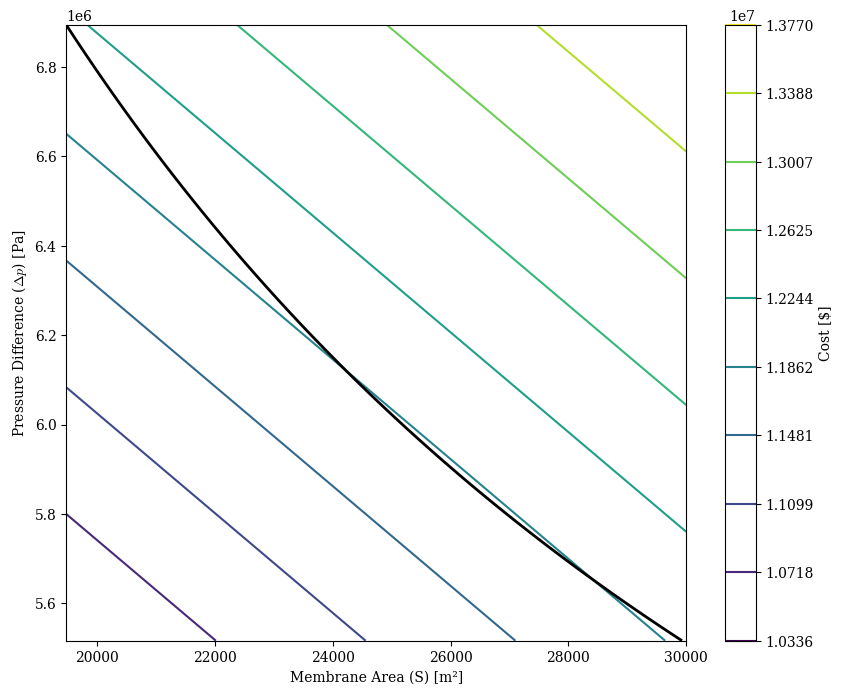

In [ ]:
delta_p_values = np.linspace(5.516e6, 6.895e6, 100)  # Bounds for delta_p
S_values = np.linspace(19470, 30000, 100)  # Bounds for S

m3_fixed = 0.005
constraint_values = np.zeros((len(delta_p_values), len(S_values)))
cost_values = np.zeros((len(delta_p_values), len(S_values)))

for i, delta_p in enumerate(delta_p_values):
    for j, S in enumerate(S_values):
        constraint_values[i, j] = constraint1([S, delta_p, m3_fixed])
        cost_values[i, j] = get_C_red([S, delta_p, m3_fixed])

plt.figure(figsize=(10, 8))

# Plotting cost function using contour
contour_cost = plt.contour(S_values, delta_p_values, cost_values, levels=np.linspace(cost_values.min(), cost_values.max(), 10), cmap='viridis')
plt.colorbar(contour_cost, label=r'Cost [\$]')

# Plotting the constraint boundary using contour
plt.contour(S_values, delta_p_values, constraint_values, levels=[0], colors='k', linewidths=2)

# Adding axis labels
plt.xlabel(r'Membrane Area (S) [m²]')
plt.ylabel(r'Pressure Difference ($\Delta p$) [Pa]')

# Show the figure
plt.show()


### Scaling of $\Delta p $ and $S$

In [178]:
def scale(value, max_value, min_value):
    return (value-min_value)/(max_value-min_value)

def unscale(value, min_value, max_value):
    return value * (max_value - min_value) + min_value

def get_C_red(x_scaled):
    S = unscale(x_scaled[0], S_min, S_max)
    delta_p = unscale(x_scaled[1], delta_p_min, delta_p_max)
    m3 = 0.005

    PR = 1500
    f = 0.4
    eta_p = 0.75
    eta_t = 0.75
    elec_cost = 0.1936
    time_running = 10

    P_pump = delta_p * PR / 3600 * (1 / eta_p)
    P_turbine = delta_p * (PR / f - PR) / 3600 * eta_t
    P_tot = (P_pump - P_turbine) / 3.6e6
    OPEX_per_s = P_tot * elec_cost
    OPEX = OPEX_per_s * time_running * 8000 * 3600

    membrane_cost = S * 150

    C_red = membrane_cost + OPEX
    return C_red


def constraint1(x_scaled):
    S = unscale(x_scaled[0], S_min, S_max)
    delta_p = unscale(x_scaled[1], delta_p_min, delta_p_max)
    m3 = 0.005

    M_A = 58.44
    M_B = 18.02
    A = 3e-7
    PR = 1500
    rho = 997
    m1 = 0.6

    delta_pi = 0.0821 * 298 * ((m1 + m1) - (m3 + m3))
    delta_pi = delta_pi * 101300

    J_B = A * (delta_p / 1000 - delta_pi / 1000)
    cons1 = (J_B * M_B * S * 3600) / (1000 / (1000 + m3 * M_A)) - PR * rho
    print(cons1)
    return cons1



S_min, S_max = 19470, 30000
delta_p_min, delta_p_max = 5.516e6, 6.895e6

x0 = [scale(29000, S_min, S_max), scale(6.3e6, delta_p_min, delta_p_max)]

bounds = [(0, 1), (0, 1)]

constraints = [{"type": "ineq", "fun": constraint1}]

result = minimize(get_C_red, x0, bounds=bounds, constraints=constraints, method='SLSQP')

optimal_S = unscale(result.x[0], S_min, S_max)
optimal_delta_p = unscale(result.x[1], delta_p_min, delta_p_max)

print("Optimal Solution: S =", optimal_S, "Delta_p =", optimal_delta_p)
print("Minimum Cost:", result.fun)
print("Initial Constraint:", constraint1(x0))
print("Constraint Value at Optimal Solution:", constraint1(result.x))

-235568.77451829007
-235568.77451829007
-235568.77451829007
-235568.7648605064
-235568.76632972807
Optimal Solution: S = 20470.0 Delta_p = 6111000.0
Minimum Cost: 11286400.0
-235568.77451829007
Initial Constraint: -235568.77451829007
-235568.77451829007
Constraint Value at Optimal Solution: -235568.77451829007


In [ ]:
delta_p_values = np.linspace(5.516e6, 6.895e6, 100)
S_values = np.linspace(19470, 30000, 100) 

10000